# Uç Değer İşlemeye Farklı Bir Bakış Açısı

### Berk Pişkin
#### 02/08/2022

Gerekli paketlerin yüklenmesi:

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.impute import SimpleImputer

Verinin okunması:

In [15]:
df = pd.read_csv("diabetes.csv")
print(df.shape)
print(df.isnull().sum())

(768, 9)
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


Verimiz 8 sayısal değişken üzerinden "diyabet" : 1 ve "diyabet değil" : 0 şeklinde sınıflandırma yapılmış popüler "Diabet" verisi.
İlk etapta 768 gözlemimiz var ve veride hiç boş değer yok. Uç değerlerin mevcutluğunu gözlemlemek adına bir boxplot çizdirelim.

<AxesSubplot:xlabel='variable', ylabel='value'>

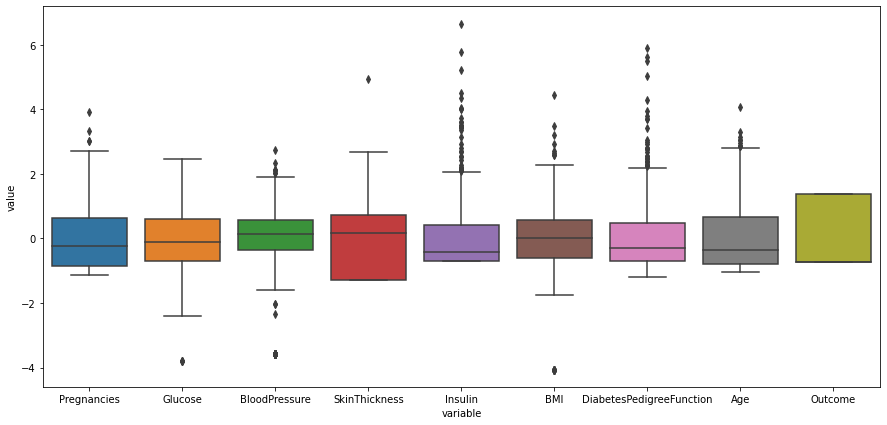

In [3]:
df_scaled = StandardScaler().fit_transform(df)
df_scaled = pd.DataFrame(df_scaled,columns=df.columns)
plt.figure(figsize=(15,7))
sns.boxplot(x="variable",y="value",data=pd.melt(df_scaled))

Görüldüğü üzere her değişkende uç değer mevcut. Bu uç değerler ile ilgilenmeden önce, karşılaştırma yapabilmek adına orjinal veride basit bir random forest modeli eğitip test skorunu elde edelim.

In [71]:
x = df.drop("Outcome",axis=1)
y = df.Outcome
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train,y_train)
print(f"Orjinal veride Random Forest skoru = {accuracy_score(rf.predict(x_test),y_test)}")

Orjinal veride Random Forest skoru = 0.7532467532467533


Sınıflandırma başarımız %75 civarı. Bakalım uç değerlerle ilgilendikten sonra başarı farkı görecek miyiz. Amacımız, orjinal verideki test başarımızı arttırmak. Bu yüzden orjinal veriye farklı yöntemler uyguladıktan sonra modifiye edilmiş veride eğittiğimiz modelleri orjinal verimizde test edeceğiz.

## Uç Değer Silme

In [72]:
df_wo = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
print(f"Uç değer bulunduran gözlem sayısı = {df.shape[0]-df_wo.shape[0]}")
print(f"Uç değer bulunduran gözlemler silindikten sonra boyut: {df_wo.shape[0]}")

Uç değer bulunduran gözlem sayısı = 80
Uç değer bulunduran gözlemler silindikten sonra boyut: 688


In [73]:
x = df_wo.drop("Outcome",axis=1)
y = df_wo.Outcome
x_train_wo,x_test_wo,y_train_wo,y_test_wo = train_test_split(x,y,test_size=0.3,random_state=42)
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_wo,y_train_wo)
print(f"Uç değer bulunduran gözlemler silindikten sonra Random Forest skoru = {accuracy_score(rf.predict(x_test),y_test)}")

Uç değer bulunduran gözlemler silindikten sonra Random Forest skoru = 0.8917748917748918


Başarı kayda değer bir şekilde yükselmiş. Ancak bu başarı başka veride yakalanamayabilir. Uç değerlerin daha fazla olduğu bir senaryoda, tüm bu gözlemleri silmek bilgi kaybına neden olur ve gelecekte sınıflandırılması gereken uç değerli bir gözlem yanlış sınıflandırılabilir.

## Uç değerleri medyan ile değiştirme

In [74]:
# Uç değerleri boş değere çevirme:
df_temp = df.copy()
for col in df.columns:
    s = df_temp[col]
    outlier_s = np.abs(stats.zscore(s)) >= 3
    df_temp[col] = s.where(~outlier_s,np.nan)

# Boş değerleri medyan ile değiştirme:
median_imputer = SimpleImputer(strategy="median")
df_imputed = median_imputer.fit_transform(df_temp)
df_imputed = pd.DataFrame(df_imputed,columns=df_temp.columns)

In [75]:
x = df_imputed.drop("Outcome",axis=1)
y = df_imputed.Outcome
x_train_imputed,x_test_imputed,y_train_imputed,y_test_imputed = train_test_split(x,y,test_size=0.3,random_state=42)
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_imputed,y_train_imputed)
print(f"Uç değer bulunduran gözlemler medyan ile değiştirildikten sonra Random Forest skoru = {accuracy_score(rf.predict(x_test),y_test)}")

Uç değer bulunduran gözlemler medyan ile değiştirildikten sonra Random Forest skoru = 0.7229437229437229


Bu yöntem ile başarımızın düştüğünü gözlemliyoruz. Ancak bir önceki yoruma benzer bir şekilde, bu yöntem kullanılarak başka bir veride başarı artışı yakalanabilir.

## Uç değerleri veriye geri kazandırma

Aşağıda kodu bulunan outlier_multiplicator veride en az bir değişkeninde uç değer bulunduran gözlemleri rastgele ve yerine koymalı seçim ile orjinal veriye geri ekler. 'ratio' parametresi, orjinal verideki uç değerli gözlem sayısının 'ratio' katı kadar ekleneceğini belirtir. 

In [93]:
def outlier_multiplicator(df,ratio):

    outliers = df[(np.abs(stats.zscore(df)) >= 3).any(axis=1)]
    print(f"Z-skor >= 3 şartı ile belirlenen uç değerli gözlem sayısı = {outliers.shape[0]}")
    print(f"Orjinal verideki gözlem sayısı = {df.shape[0]}")
    df_multiplied = pd.concat([outliers.sample(int(outliers.shape[0]*ratio),replace=True),df],axis=0)
    df_multiplied.reset_index(inplace=True)
    df_multiplied.drop("index",axis=1,inplace=True)
    print(f"Uç değerler çoğaltıldıktan sonraki gözlem sayısı = {df_multiplied.shape[0]}")
    return df_multiplied

In [94]:
df_multiplied = outlier_multiplicator(df,8)

Z-skor >= 3 şartı ile belirlenen uç değerli gözlem sayısı = 80
Orjinal verideki gözlem sayısı = 768
Uç değerler çoğaltıldıktan sonraki gözlem sayısı = 1408


In [95]:
x = df_multiplied.drop("Outcome",axis=1)
y = df_multiplied.Outcome
x_train_multiplied,x_test_multiplied,y_train_multiplied,y_test_multiplied = train_test_split(x,y,test_size=0.3,random_state=42)
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_multiplied,y_train_multiplied)
print(f"Uç değer bulunduran gözlemler medyan ile değiştirildikten sonra Random Forest skoru = {accuracy_score(rf.predict(x_test),y_test)}")

Uç değer bulunduran gözlemler medyan ile değiştirildikten sonra Random Forest skoru = 0.948051948051948


Sonuç : Uç değerleri veriye geri kazandırma mantığı ile hyper-tuning bile yapmadan %95'e yakın başarı yakalayabilmiş olduk.